# Avazu CTR Prediction

### Model Summaries: The best ROC AUC Score for each model.

#### Best Logistic Regression: 0.6955

#### Best Gradient Boosting: 0.6955

### Best Xgboost: 0.7383

#### Best Random Forest: 0.7367

XGboost had the best perfomance among the models. 

todo-Explain why.

## Imports

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import sklearn
import matplotlib.dates as mdates
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

### Ignore Warnings

In [2]:
'''Ignore Warning Messages'''
import warnings
warnings.filterwarnings('ignore')

### Matplotlib Style

In [3]:
'''Set style to GGplot for asthetics'''
matplotlib.style.use('ggplot')


### Sample and Import Dataset

In [4]:
''' Sample from Training Data down to 1 million records'''

n = 40428966  #total number of records in the dataset 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

#Tracking the indices of rows to be skipped at random

In [5]:
df = pd.read_csv('train.csv', skiprows = skip_values)

## Data Prepation

### Date Time conversion with Hour feature

In [6]:
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

### Create weekday and datetime from hour

In [7]:
df['weekday'] = df['hour'].apply(lambda x : datesplit(x).weekday()) 

In [8]:
df['hour'] = df['hour'].apply(lambda x : datesplit(x).hour)

### Vizualizations

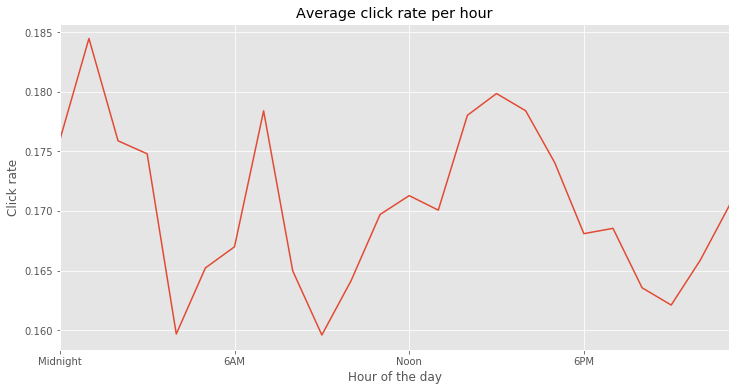

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['hour'])['click'].mean())
plt.xlabel("Hour of the day")
plt.ylabel("Click rate")
plt.title("Average click rate per hour")
plt.xticks(np.arange(0, 23, step=6), ('Midnight', '6AM', 'Noon', '6PM'))
plt.xlim([0.0, 23.0])
plt.show()

Users click on ads the most around 1 AM, 7AM, and 3PM.
They click on ads the least around 4AM, 9AM, and 8 PM.

This suggests that the best time to run ads for maximum impressions is just after midnight, but not too late, early in the morning but before the work commute begins, and in the afternoon. This maps well with when workers are least prodcutive at work, the afternoon. During the evening users may be engaging in activities outside of a screen, but later at night they are back on the internet.

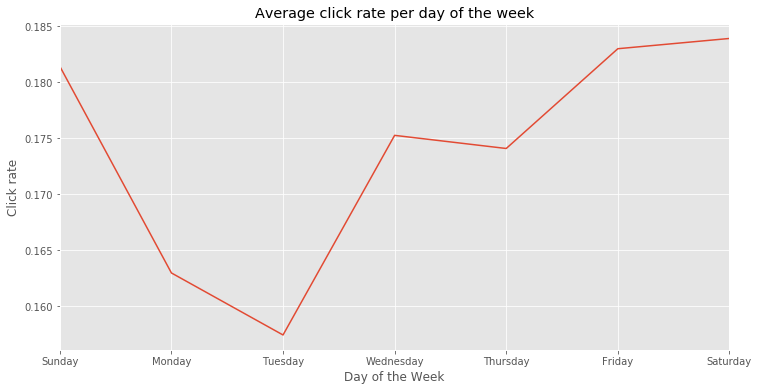

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['weekday'])['click'].mean())
plt.xlabel("Day of the Week")
plt.xticks(np.arange(0, 7, step=1), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',))
plt.xlim([0.0, 6.0])
plt.ylabel("Click rate")
plt.title("Average click rate per day of the week")
plt.show()

Users click on ads the most on the weekend, which suggests that when users have free time, they are spending it online. Tuesday and Monday are the worst days for ads, and as we get closer to the weekend, click rates improve.

### Variable Encoding

In [11]:
model_features = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

In [12]:
model_target = 'click'

In [13]:
train_model = df[model_features+[model_target]]

In [14]:
train_model = df[model_features+[model_target]]

In [15]:
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                     columns = feature_set,
                                    sparse = True)

    return new_data_frame

In [16]:
train_model = one_hot_features(train_model, ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'])

In [17]:
model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

In [18]:
X = train_model[model_features].values

In [19]:
y = train_model[model_target].values

### Test Train Splt

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1,
                                                 random_state=100)

## Modeling

### Linear Regression

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
hard = lr.predict(Xtest)
soft = lr.predict_proba(Xtest)

In [23]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(ytest, soft[:,1]) 

#### Plot the roc curve

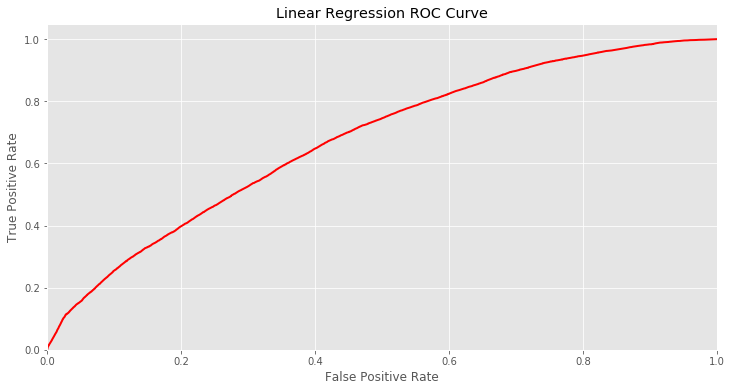

In [24]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear Regression ROC Curve')
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.6761374117467103


### Confusion Matrix

In [26]:
y_pred = lr.predict(Xtest)
predictions = [round(value) for value in y_pred]

In [27]:
from sklearn import metrics

print(confusion_matrix(ytest, predictions))

[[82938    78]
 [16828   157]]


### Add site and user

In [28]:
values = df['device_id'].value_counts().idxmax() 

df['user'] = np.where(df['device_id'] == values, df['device_ip'] + df['device_model'], df['device_id']) 

In [29]:
df = df.drop(['device_id', 'device_model', 'device_ip'], axis=1) 


In [30]:
df['site'] = df['site_id'] + df['site_domain'] 


In [31]:
df = df.drop(['site_id', 'site_domain'], axis=1)


### Create another test train split

In [32]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=100)

In [33]:
n_ones = np.array(Xtrain.sum(axis=0))


In [34]:
useful = n_ones > 100 


In [35]:
import collections
collections.Counter(useful)

Counter({True: 149, False: 35})

In [36]:
cols_to_keep = [i*b for i,b in enumerate(useful) if b == True]


In [37]:
Xtrain = Xtrain[:,cols_to_keep] 

In [38]:
Xtest = Xtest[:,cols_to_keep]


### Run another logistic regression

In [39]:
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
hard = lr.predict(Xtest)


In [41]:
y_pred = lr.predict(Xtest)
predictions = [round(value) for value in y_pred]

In [42]:
print("The ROC AUC is : " + str(roc_auc_score(ytest, predictions)))
#Explore further, variable error?

The ROC AUC is : 0.5037288364799529


In [43]:
from sklearn import metrics

print(confusion_matrix(ytest, predictions))

[[165794    141]
 [ 33783    283]]


### Gradient Boosting

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.8, verbose=True) 
gb.fit(Xtrain, ytrain)

      Iter       Train Loss   Remaining Time 
         1           0.8757            2.29m
         2           0.8665            2.50m
         3           0.8629            2.32m
         4           0.8615            2.10m
         5           0.8594            1.96m
         6           0.8578            1.90m
         7           0.8564            1.80m
         8           0.8536            1.73m
         9           0.8519            1.66m
        10           0.8508            1.63m
        20           0.8449            1.19m
        30           0.8404           48.12s
        40           0.8386           23.62s
        50           0.8373            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False)

In [45]:
soft = gb.predict_proba(Xtest)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.6968648729396837


In [46]:
y_pred = lr.predict(Xtest)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

[[165794    141]
 [ 33783    283]]


### Create leaves from gradient boosting

In [47]:
leaves_train = gb.apply(Xtrain)[:,:,0] 
leaves_test = gb.apply(Xtest)[:,:,0] 

In [48]:
leaves_train = pd.DataFrame(leaves_train) 
leaves_test = pd.DataFrame(leaves_test)

### Encoding

In [49]:
encoder = OneHotEncoder(handle_unknown = 'ignore') 
leaves_train_encoded = encoder.fit_transform(leaves_train)
leaves_test_encoded = encoder.transform(leaves_test)

In [50]:
from scipy.sparse import csr_matrix, hstack
Xtrain_hstack = hstack([ Xtrain, leaves_train_encoded]) 

In [51]:
Xtest_hstack = hstack([ Xtest, leaves_test_encoded])

### Logistic Regression on new data

In [52]:
lr = LogisticRegression()
lr.fit(Xtrain_hstack, ytrain)
lr.predict(Xtest_hstack)
soft = gb.predict_proba(Xtest)
roc_auc_score(ytest, soft[:,1])

0.6968648729396837

### XGBoost

In [54]:
!pip install xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 50,n_jobs = -1,learning_rate = 0.8)
xgb.fit(Xtrain_hstack, ytrain)

    100% |████████████████████████████████| 114.0MB 535kB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [55]:
xgb.predict(Xtrain_hstack)
soft = xgb.predict_proba(Xtest_hstack)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.7004658267854944


In [56]:
y_pred = xgb.predict(Xtest_hstack)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

[[164938    997]
 [ 32652   1414]]


## Hashing

### Create new test train split

In [57]:
X = df.drop(['click'], axis=1)
y = df['click']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=100)

### Hashing Function

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        
        for i in range(len(self.col_names)):
            serie = X[self.col_names[i]].value_counts()  # Series of each column
            rare_indexes = serie[serie<self.threshold[i]].index  # The indexes for least frequent features
            frequent_indexes = serie[serie>=self.threshold[i]].index  # The indexes for most frequent features
            dictionary = {x:'isRare' for x in rare_indexes}
            dictionary.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dictionary)   # Index for rare and most frequent
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
                
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
        # Represent the new features never observed and apply the count_dict to ther rest

        return Xt

In [59]:
merged = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_merged = merged.fit_transform(Xtrain)
Xtest_merged = merged.transform(Xtest)

### Test Hash

In [60]:
import hashlib
hash('test hash') 

418663506475233019

### Hash the Dataframe

In [62]:
Xtrain_hashed = pd.DataFrame()
Xtest_hashed = pd.DataFrame()
for col in Xtrain_merged.columns:
    Xtrain_hashed[col] = Xtrain_merged[col].apply(lambda x : hash(str(x)) % 1000000) 
    Xtest_hashed[col] = Xtest_merged[col].apply(lambda x : hash( str(x)) % 1000000)

### Confirm Hashing

In [63]:
Xtrain_hashed.tail() 

,id,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,...,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
864087,35949,167227,946963,408414,78373,960279,366770,690493,46478,540522,...,609470,886077,317499,953645,354585,584181,412522,400738,35949,341726
778087,35949,769960,524745,408414,565074,690940,366770,932816,408414,540522,...,609470,886077,248285,540522,257183,584181,470159,408414,35949,649092
210755,35949,486501,524745,540522,565074,690940,366770,932816,408414,540522,...,609470,886077,633106,540522,352671,584181,470159,400738,901699,700616
56088,35949,63916,524745,540522,110006,690940,366770,932816,408414,540522,...,609470,886077,72411,540522,352671,584181,470159,408414,35949,435516
824840,35949,581298,524745,408414,565074,690940,366770,932816,408414,540522,...,609470,886077,761304,953645,982984,342104,678830,400738,980804,663847


In [64]:
Xtest_hashed.head()


,id,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,...,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
910289,35949,46478,524745,540522,78373,79044,15119,690493,408414,540522,...,609470,886077,612824,953645,642182,584181,834476,953645,35949,341726
501821,35949,953645,524745,540522,453408,690940,366770,932816,408414,540522,...,609470,886077,862895,953645,257183,584181,167149,581298,35949,35949
119646,35949,371404,524745,408414,565074,690940,366770,932816,408414,540522,...,609470,886077,233430,540522,566528,775226,758427,400738,35949,46968
779798,35949,769960,524745,540522,78373,875837,924686,690493,408414,953645,...,609470,886077,9126,408414,432529,309643,485132,408414,35949,341726
316955,35949,138221,524745,540522,78373,843268,238627,690493,408414,540522,...,609470,886077,443117,400738,257183,999222,41784,953645,35949,341726


### Random Forests

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1024, min_samples_leaf = 20, verbose = False, n_jobs = -1)
rf.fit(Xtrain_hashed, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1024, n_jobs=-1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [66]:
soft = rf.predict_proba(Xtest_hashed)


In [67]:
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.7376987890890206


In [68]:
y_pred = rf.predict(Xtest_hashed)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

[[164562   1373]
 [ 31935   2131]]


### XGboost

In [69]:
xgb = XGBClassifier(n_estimators = 1024,n_jobs = -1,learning_rate = 1)
xgb.fit(Xtrain_hashed, ytrain) 
soft = xgb.predict_proba(Xtest_hashed)
print("The ROC AUC is : " + str(roc_auc_score(ytest, soft[:,1])))

The ROC AUC is : 0.7394307013189181


In [70]:
y_pred = xgb.predict(Xtest_hashed)
predictions = [round(value) for value in y_pred]
print(confusion_matrix(ytest, predictions))

[[163677   2258]
 [ 31152   2914]]


In [71]:
fpr, tpr, thresholds = roc_curve(ytest, soft[:,1]) 

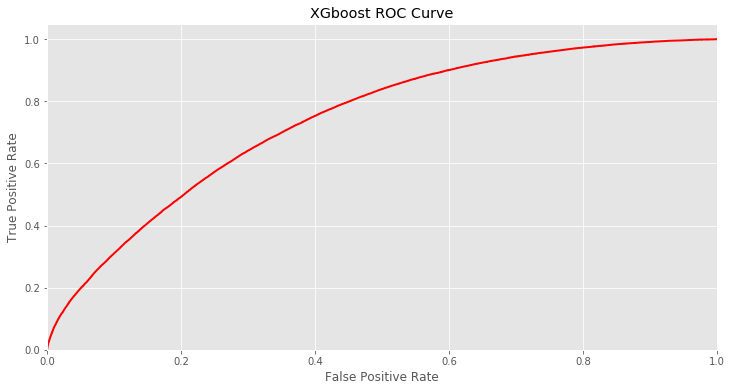

In [72]:
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGboost ROC Curve')
plt.show()